In [11]:
import csv
import sys
import os
from pathlib import Path
import subprocess
import time
import torch



In [46]:
ash.GetAtomWithIdx

<bound method GetAtomWithIdx of <rdkit.Chem.rdchem.Mol object at 0x00000256F5B881C0>>

In [34]:
DATA_PATH        = "./data/pre-training/"
DATASET          = "gdb13_1K-debug"    # dataset name in "./data/pre-training/"
JOB_TYPE         = "train"             # "preprocess", "train", "generate", or "test"
params = {
    "atom_types"   : ["C", "N", "O", "S", "Cl",'I'],
    "formal_charge": [-1, 0, +1],
    "max_n_nodes"  : 13,
    "job_type"     : JOB_TYPE,
    "dataset_dir"  : f"{DATA_PATH}{DATASET}/",
    "restart"      : 1,
    "model"        : "GGNN",
    "sample_every" : 2,
    "init_lr"      : 1e-4,
    "epochs"       : 100,
    "batch_size"   : 50,
    "block_size"   : 1000,
    "device"       : 'cuda',
    "n_samples"    : 100,
    # additional paramaters can be defined here, if different from the "defaults"
    # for instance, for "generate" jobs, don't forget to specify "generation_epoch"
    # and "n_samples"
}
max_nodes=13
n_node_features=1288#check/calculate them
n_edge_features = 1289#calculate them
dim_nodes = [max_nodes, n_node_features]
dim_edges = [max_nodes, max_nodes, n_edge_features]

In [54]:
with rdkit.Chem.ForwardSDMolSupplier('data\pre-training\GDB13_Subset-ABCDEFGH.smi') as fsuppl:
    for mol in fsuppl:
        print(mol)
        if mol is None:continue
        print(mol.GetNumAtoms())


None


In [56]:
import gzip
inf = gzip.open('data\pre-training\GDB13_Subset-ABCDEFGH.smi.gz')
with rdkit.Chem.ForwardSDMolSupplier(inf) as gzsuppl:
    ms = [x for x in gzsuppl if x is not None]
len(ms)


0

In [65]:
def unzip_dataset(path):
    # logger.info("Unzipping dataset")
    with gzip.open(path) as smi:
        lines = smi.readlines()
    return lines


In [68]:
dataset = unzip_dataset('data\pre-training\GDB13_Subset-ABCDEFGH.smi.gz')

In [69]:
dataset

[b'S1C=CC=C1\n',
 b'O1C=CC=C1\n',
 b'C1CCCC1\n',
 b'N1C=CC=C1\n',
 b'S1C=CC=N1\n',
 b'S1C=CN=C1\n',
 b'O1C=CC=N1\n',
 b'O1C=CN=C1\n',
 b'C1CCOC1\n',
 b'C1=CC=CC=C1\n',
 b'ClC1=CSC=C1\n',
 b'ClC1=COC=C1\n',
 b'C1CCCCC1\n',
 b'C1CC[NH2+]C1\n',
 b'ClC1=CNC=C1\n',
 b'C1=CC=NC=C1\n',
 b'C1CCOCC1\n',
 b'O=C1CCCC1\n',
 b'ClC1=CC=CC=C1\n',
 b'C1CC[NH2+]CC1\n',
 b'[O-]C1=CC=CS1\n',
 b'[O-]C1=CC=CO1\n',
 b'[O-]C1=COC=C1\n',
 b'O=C1O[CH-]C=C1\n',
 b'OC1=CSC=C1\n',
 b'OC1CCCC1\n',
 b'C1=CC=NN=C1\n',
 b'C1=CN=CC=N1\n',
 b'C1=CN=CN=C1\n',
 b'C1COCCO1\n',
 b'C1COCOC1\n',
 b'[NH3+]C1CCCC1\n',
 b'NC1=CC=CS1\n',
 b'NC1=CSC=C1\n',
 b'NC1=CC=CO1\n',
 b'NC1=COC=C1\n',
 b'O=C1CCCN1\n',
 b'O=C1CCOC1\n',
 b'ClC1=CNC=C1Cl\n',
 b'ClC1=CC=CN=C1\n',
 b'ClC1=CC=NC=C1\n',
 b'C1CCCOCC1\n',
 b'C1COCC[NH2+]1\n',
 b'OC1=CC=CN1\n',
 b'OC1=CNC=C1\n',
 b'OC1CCOC1\n',
 b'O=C1OC=CC=C1\n',
 b'O=C1CCCCC1\n',
 b'O=C1CC[NH2+]C1\n',
 b'[NH3+]C1CCOC1\n',
 b'NC1=CC=CN1\n',
 b'NC1=CNC=C1\n',
 b'C1CNC=[NH+]C1\n',
 b'C1CCC[NH2+]CC1\n

In [78]:
from rdkit.Chem.rdmolfiles import SmilesMolSupplier
def load_molecule(path):
    with open(path) as smi_file:
        first_line = smi_file.readline()
        has_header = bool("SMILES" in first_line)
        print(has_header)
    smi_file.close()

    molecule_set = SmilesMolSupplier(path,
                                     sanitize=True,
                                     nameColumn=-1,
                                     titleLine=has_header)
    return molecule_set
path = "data\pre-training\gdb13_1K\Train.h5"
molecule_set = load_molecule(path)
print(molecule_set)

False


In [83]:
alasla = SmilesMolSupplier('data\pre-training\gdb13_1K\Train.smi',
                                     sanitize=True,
                                     nameColumn=-1,
                                    )
for i in alasla:
    rdkit.Chem.MolToSmiles(i)  
print(len(alasla))


979


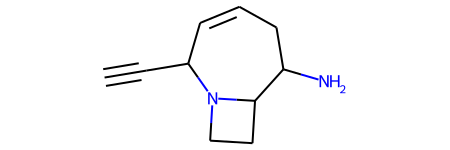

In [98]:
alasla[130]

In [60]:
ash=[]
for x in molecule_set:
    ash.append(x)


In [102]:
for i in alasla[130].GetBonds():
    print(i)

In [63]:
len(ash)

13

In [64]:
!pip install molsets

  Running setup.py clean for pomegranate
Failed to build pomegranate
    Running setup.py install for pomegranate: started
    Running setup.py install for pomegranate: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\ASHISH\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\ASHISH\\AppData\\Local\\Temp\\pip-install-asu0vblm\\pomegranate_2ac2dcb7fc514957838b9ec94e4499ac\\setup.py'"'"'; __file__='"'"'C:\\Users\\ASHISH\\AppData\\Local\\Temp\\pip-install-asu0vblm\\pomegranate_2ac2dcb7fc514957838b9ec94e4499ac\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\ASHISH\AppData\Local\Temp\pip-wheel-bcr3a2u9'
       cwd: C:\Users\ASHISH\AppData\Local\Temp\pip-install-asu0vblm\pomegranate_2ac2dcb7fc514957838b9ec94e4499ac\
  Complete output (102 lines):
  running bdist_whee

In [7]:
ash.GetNumAtoms()
for atom in ash.GetAtoms():
   print(atom.GetAtomicNum())
ash.GetAtomWithIdx(0).GetSymbol()

53


'I'

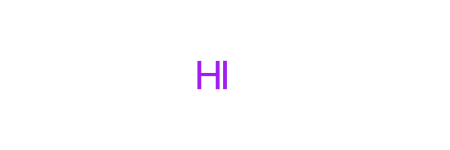

In [24]:
for m in molecule_set:
    if m!=None:
        ash = m
ash

In [13]:
n_molecules = len(molecule_set)
counting_the_subgraphs = total_n_subgraphs = get_n_subgraphs()#now ganda code will going to start

In [16]:
def get_n_subgraphs (molecule_set):
    n_subgraphs=0
    moleculer_graph_generator = map(get_graph,molecule_set)
    # for moleculer_g in moleculer_graph_generator:
    #     n_subgraphs+=moleculer_g.get_decoding_route_length()
    """
    #1.get graph function
    #2.decoding route function
    """

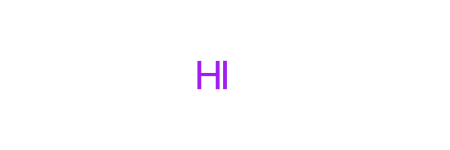

In [50]:
ash

In [20]:
get_n_subgraphs(molecule_set)

In [48]:
ash.GetSymbol()

AttributeError: 'Mol' object has no attribute 'GetSymbol'

In [51]:
#1
import numpy as np
from rdkit.Chem.rdchem import BondType
import rdkit,itertools
bondtype_to_int = {BondType.SINGLE: 0, BondType.DOUBLE: 1, BondType.TRIPLE: 2}
int_to_bondtype = dict(map(reversed, bondtype_to_int.items()))
n_edge_features = len(bondtype_to_int)
from typing import Union,TypeVar

def get_graph(mol):#its required becz right now r graph is in chem function and we need to covnert into a subitable python graph
    mol_to_graph(mol)
    node_remap(mol)
    

#class PreprocessingGraph(MoleculerGraph)
# molecule_set.GetNumAtoms()
def mol_to_graph(molecule):
    n_nodes = molecule.GetNumAtoms()
    n_atoms = n_nodes
    atoms = molecule.GetAtomWithIdx
    print("here is the thing ",atoms)

    node_features = np.array(atom_features(atoms),dtype=np.int32)#here atom features also needs to make
    edge_features = np.zeros([n_atoms,n_atoms,n_edge_features],dtype=np.int32)
    for bond in molecule.GetBonds():
        i=bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        bond_type = bondtype_to_int[bond.GetBondType()]
        edge_features[i, j, bond_type] = 1
        edge_features[j, i, bond_type] = 1


def atom_features( atom : rdkit.Chem.Atom) -> np.ndarray:
    if  True:#def one_of_k_encoding(x: Union[str,int],allowable_set:list):
        feature_vector=[]
        x = atom.GetSymbol()
        for s in params["atom_types"]:
            # print("hello ",x,'chello ',s,int(x==s))
            one_hot_generator = (int(x==s) )
            feature_vector.append(one_hot_generator)
        x =  atom.GetFormalCharge()
        for s in params["formal_charge"]:
            # print("hello ",'chello ',s,int(x==s))
            one_hot_generator = (int(x==s) )
            feature_vector.append(one_hot_generator)
    # print(atom.GetSymbol(),params["atom_types"])
    # print(atom.GetFormalCharge(), params["formal_charge"])
    # feature_vector_generator = itertools.chain(
    #         one_of_k_encoding(atom.GetSymbol(),params["atom_types"]),
    #         one_of_k_encoding(atom.GetFormalCharge(),
    #                                params["formal_charge"])
    #     )
    # print("jamele ",feature_vector_generator)

    # feature_vector = np.fromiter(feature_vector_generator, int)
    return feature_vector



mol_to_graph(molecule=ash)#chem obj to graph python



here is the thing  <bound method GetAtomWithIdx of <rdkit.Chem.rdchem.Mol object at 0x00000256F5B881C0>>


AttributeError: 'Boost.Python.function' object has no attribute 'GetSymbol'

In [19]:
def node_remap(mol):
    atom_ranking = list(
                rdkit.Chem.CanonicalRankAtoms(mol, breakTies=True)
            )    
    node_ordering = breadth_first_search(node_ranking=atom_ranking,
                                                           node_init=atom_ranking[0])
    reorder_nodes()
def reorder_nodes() -> None:
        """
        Remaps the numerical ordering of nodes in the graph as specified by the
        `self.node_ordering`. Modifies the `PreprocessingGraph` in place.
        """
        # first remap the node features matrix
        node_features_remapped = np.array(
            [self.node_features[node] for node in self.node_ordering],
            dtype=np.int32
        )

        # then remap the edge features tensor
        edge_features_rows_done = np.array(
            [self.edge_features[node, :, :] for node in self.node_ordering],
            dtype=np.int32
        )
        edge_features_remapped = np.array(
            [edge_features_rows_done[:, node, :] for node in self.node_ordering],
            dtype=np.int32
        )

        self.node_features = node_features_remapped
        self.edge_features = edge_features_remapped

In [17]:
# with open(path) as smi_file:
#         first_line = smi_file.readlines()
#         count=0
#         for l in first_line:
#             print(l)
#             if count>100:
#                 break
#             count+=1

In [5]:
path = 'E:\graph gnn\GraphINVENT\data\pre-training\gdb13_1K\train.h5'
path            = path
is_training_set = True
dataset_names   = ["nodes", "edges", "APDs"]
 # creates `self.dims`

In [6]:
9import rdkit


In [18]:
def breadth_first_search(self, node_ranking : list,
                             node_init : int=0) -> list:
       
        nodes_visited      = [node_init]
        last_nodes_visited = [node_init]

        # loop until all nodes have been visited
        while len(nodes_visited) < self.n_nodes:
            neighboring_nodes = []

            for node in last_nodes_visited:
                neighbor_nodes = []
                for bond_type in range(self.constants.n_edge_features):
                    neighbor_nodes.extend(list(
                        np.nonzero(self.edge_features[node, :, bond_type])[0]
                    ))
                new_neighbor_nodes = list(
                    set(neighbor_nodes) - (set(neighbor_nodes) & set(nodes_visited))
                )
                node_importance = [node_ranking[neighbor_node] for
                                      neighbor_node in new_neighbor_nodes]

                # check all neighboring nodes and sort in order of importance
                while sum(node_importance) != -len(node_importance):
                    next_node = node_importance.index(max(node_importance))
                    neighboring_nodes.append(new_neighbor_nodes[next_node])
                    node_importance[next_node] = -1

            # append the new, sorted neighboring nodes to list of visited nodes
            nodes_visited.extend(set(neighboring_nodes))

            # update the list of most recently visited nodes
            last_nodes_visited = set(neighboring_nodes)

        return nodes_visited

In [ ]:
train_set_preprocesser = DataProcesser(path=self.constants.training_set,
                                               is_training_set=True)
train_set_preprocesser.preprocess()

In [32]:
import numpy as np
#edges=np.ones((10,10,4))
jm = list(np.nonzero(edges[2,:,0])[0])
print(edges[2,:,0])
jm

[0. 0. 0. 1. 1. 0. 0.]


[3, 4]

In [26]:
edges[2,:,2]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [2]:
import numpy as np

edges = np.zeros((7,7,1))
edges[0,1]=1
edges[1,2]=1
edges[2,3]=1
edges[2,4]=1
edges[1,6]=1
edges[5,4]=1
edges[1,5]=1


In [3]:
edges
import random
node_ranking = [i for i in range(0,6)]
random.shuffle(node_ranking)

In [4]:
nodes_visited      = [1]
last_nodes_visited = [1]
count=0
n_nodes = len(node_ranking)
while len(nodes_visited) < n_nodes:
    
    count+=1
    neighbouring_nodes = []
    for node in last_nodes_visited:
        #if node not in nodes_visited:
        print("node is ",node)
        neighbour_nodes=[]
        for bond_type in range(1):
            neighbour_nodes.extend(list(np.nonzero(edges[node,:,bond_type])[0]
            ))
        print(neighbour_nodes,' ',nodes_visited)
        new_neighbour_nodes = list(set(neighbour_nodes)-(set(neighbour_nodes)&set(nodes_visited)))
        last_nodes_visited.remove(node)
        last_nodes_visited.extend(set(new_neighbour_nodes))
        nodes_visited.append(node)
    
            

node is  1
[2, 5, 6]   [1]
node is  5
[4]   [1, 1]
node is  4
[]   [1, 1, 5]
node is  2
[3, 4]   [1, 1, 5, 4]
node is  3
[]   [1, 1, 5, 4, 2]


In [11]:
nodes_visited

[1, 1, 5, 4, 2, 3]

In [12]:
set(nodes_visited)

{1, 2, 3, 4, 5}